In [15]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
import hopsworks

In [16]:
# 1 -> external dataset, 2 -> local labelled data, 3 -> Hopsworks labelled data
USE_HOPSWORKS = True

if USE_HOPSWORKS:
    project = hopsworks.login()
    feature_store = project.get_feature_store()
    article_feature_group = feature_store.get_feature_group(name="training_data_stance", version=1)
    data = article_feature_group.read()
    data = data.rename(columns={'title': 'title', 'predicted_topic': 'subjects', 'stance': 'stance'})
    # as somehow Hopsworks ended up with NaNs at random rows, filter these rows
    data = data[data['stance'].notnull()]
    # convert from 1=neg, 2=neu, 3=pro to 0=neg, 1=neu, 2=pro
    data['stance'] = data['stance']-1
    data['stance'] = data['stance'].astype('category')
else:
    data = pd.read_csv('data/stance_data.csv')
    data = data.rename(columns={'post': 'title', 'new_topic': 'subjects', 'label': 'stance'})
    data['stance'] = data['stance'].astype('category')
    # convert from 0=neg, 1=pro, 2=neu to 0=neg, 1=neu, 2=pro
    neu = data['stance'] == 1
    data.loc[data['stance'] == 2, 'stance'] = 1
    data.loc[neu, 'stance'] = 2

display(data)

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/5270
Connected. Call `.close()` to terminate connection gracefully.
2023-01-01 14:15:46,994 INFO: USE `scalablemltask1_featurestore`
2023-01-01 14:15:47,487 INFO: SELECT `fg0`.`title` `title`, `fg0`.`saved_at` `saved_at`, `fg0`.`url` `url`, `fg0`.`stance` `stance`, `fg0`.`title_stance` `title_stance`, `fg0`.`title_topic` `title_topic`, `fg0`.`predicted_topic` `predicted_topic`
FROM `scalablemltask1_featurestore`.`training_data_stance_1` `fg0`


,title,saved_at,url,stance,title_stance,title_topic,subjects
1,"Stocks making the biggest moves midday: Netflix, Snap, Warner Bros. Discovery, AT&T, Novavax and more - CNBC",16/12/2022 09:23,https://www.cnbc.com/2022/12/15/stocks-making-the-biggest-moves-midday-netflix-snap-warner-bros-discovery-att-novavax-and-more-.html,1.0,stocks making the biggest moves midday netflix snap warner bros discovery at t novavax and more cnbc,stocks making biggest moves midday netflix snap warner bros discovery novavax cnbc,"stock, market, analyst"
2,Intel 13th Gen non-K CPUs are 28% to 64% faster than 12th Gen according to leaked tests - VideoCardz.com,15/12/2022 10:05,https://videocardz.com/newz/intel-13th-gen-non-k-cpus-are-28-to-64-faster-than-12th-gen-according-to-leaked-tests,2.0,intel 13th gen non k cpus are 28 to 64 faster than 12th gen according to leaked tests videocardz com,intel 13th gen non k cpus 28 64 faster 12th gen according leaked tests videocardz com,"videocardz, max, inch"
3,"Religion is not the factor that most influences rejection of evolutionary theory in schools, study says - Phys.org",15/12/2022 23:53,https://phys.org/news/2022-12-religion-factor-evolutionary-theory-schools.html,2.0,religion is not the factor that most influences rejection of evolutionary theory in schools study says phys org,religion factor influences rejection evolutionary theory schools study says phys org,"neuroscience, alzheimer, brain"
4,Let's a-go! Super Nintendo World sets Universal Studios opening date - The A.V. Club,15/12/2022 10:04,https://www.avclub.com/super-nintendo-world-universal-studios-hollywood-opens-1849893923,2.0,let s a go super nintendo world sets universal studios opening date the a v club,let go super nintendo world sets universal studios opening date v club,"nintendo, gematsu, switch"
5,What parents should know about Covid vaccine boosters for kids age 5 and under - CNN,15/12/2022 10:04,https://www.cnn.com/2022/12/14/health/covid-bivalent-vaccine-young-children-wellness/index.html,1.0,what parents should know about covid vaccine boosters for kids age 5 and under cnn,parents know covid vaccine boosters kids age 5 cnn,"covid, vaccines, 19"
...,...,...,...,...,...,...,...
585,"S.T.A.L.K.E.R. 2: Heart of Chornobyl ‘Come to Me’ gameplay trailer, screenshots - Gematsu",30/12/2022 10:16,https://www.gematsu.com/2022/12/stalker-2-heart-of-chornobyl-come-to-me-gameplay-trailer-screenshots,1.0,s t a l k e r 2 heart of chornobyl come to me gameplay trailer screenshots gematsu,l k e r 2 heart chornobyl come gameplay trailer screenshots gematsu,"nintendo, gematsu, switch"
586,"Officials in Buffalo, New York, face questions about storm planning and response as harrowing accounts emerge of death and survival - CNN",29/12/2022 20:05,https://www.cnn.com/2022/12/29/weather/buffalo-winter-storm-new-york-blizzard-thursday/index.html,0.0,officials in buffalo new york face questions about storm planning and response as harrowing accounts emerge of death and survival cnn,officials buffalo new york face questions storm planning response harrowing accounts emerge death survival cnn,"storm, power, winter"
587,12 amazing James Webb Space Telescope discoveries of 2022 - Space.com,30/12/2022 10:16,https://www.space.com/james-webb-space-telescope-12-amazing-discoveries-2022,2.0,12 amazing james webb space telescope discoveries of 2022 space com,12 amazing james webb space telescope discoveries 2022 space com,"webb, telescope, james"
588,N. Korea fires 3 missiles amid tensions over drone flights - ABC News,31/12/2022 17:13,https://abcnews.go.com/International/wireStory/north-korea-fires-missile-sea-south-korea-95994313,0.0,n korea fires 3 missiles amid tensions over drone flights abc news,n korea fires 3 missiles amid tensions drone flights abc news,"ukraine, russia, war"


In [17]:
# data_train = data
X_train, X_test, y_train, y_test = train_test_split(data[['title', 'subjects']], data['stance'], test_size=0.33)

pd.set_option('display.max_colwidth', None)
display(data)
print(data.dtypes)

display(X_train)

,title,saved_at,url,stance,title_stance,title_topic,subjects
1,"Stocks making the biggest moves midday: Netflix, Snap, Warner Bros. Discovery, AT&T, Novavax and more - CNBC",16/12/2022 09:23,https://www.cnbc.com/2022/12/15/stocks-making-the-biggest-moves-midday-netflix-snap-warner-bros-discovery-att-novavax-and-more-.html,1.0,stocks making the biggest moves midday netflix snap warner bros discovery at t novavax and more cnbc,stocks making biggest moves midday netflix snap warner bros discovery novavax cnbc,"stock, market, analyst"
2,Intel 13th Gen non-K CPUs are 28% to 64% faster than 12th Gen according to leaked tests - VideoCardz.com,15/12/2022 10:05,https://videocardz.com/newz/intel-13th-gen-non-k-cpus-are-28-to-64-faster-than-12th-gen-according-to-leaked-tests,2.0,intel 13th gen non k cpus are 28 to 64 faster than 12th gen according to leaked tests videocardz com,intel 13th gen non k cpus 28 64 faster 12th gen according leaked tests videocardz com,"videocardz, max, inch"
3,"Religion is not the factor that most influences rejection of evolutionary theory in schools, study says - Phys.org",15/12/2022 23:53,https://phys.org/news/2022-12-religion-factor-evolutionary-theory-schools.html,2.0,religion is not the factor that most influences rejection of evolutionary theory in schools study says phys org,religion factor influences rejection evolutionary theory schools study says phys org,"neuroscience, alzheimer, brain"
4,Let's a-go! Super Nintendo World sets Universal Studios opening date - The A.V. Club,15/12/2022 10:04,https://www.avclub.com/super-nintendo-world-universal-studios-hollywood-opens-1849893923,2.0,let s a go super nintendo world sets universal studios opening date the a v club,let go super nintendo world sets universal studios opening date v club,"nintendo, gematsu, switch"
5,What parents should know about Covid vaccine boosters for kids age 5 and under - CNN,15/12/2022 10:04,https://www.cnn.com/2022/12/14/health/covid-bivalent-vaccine-young-children-wellness/index.html,1.0,what parents should know about covid vaccine boosters for kids age 5 and under cnn,parents know covid vaccine boosters kids age 5 cnn,"covid, vaccines, 19"
...,...,...,...,...,...,...,...
585,"S.T.A.L.K.E.R. 2: Heart of Chornobyl ‘Come to Me’ gameplay trailer, screenshots - Gematsu",30/12/2022 10:16,https://www.gematsu.com/2022/12/stalker-2-heart-of-chornobyl-come-to-me-gameplay-trailer-screenshots,1.0,s t a l k e r 2 heart of chornobyl come to me gameplay trailer screenshots gematsu,l k e r 2 heart chornobyl come gameplay trailer screenshots gematsu,"nintendo, gematsu, switch"
586,"Officials in Buffalo, New York, face questions about storm planning and response as harrowing accounts emerge of death and survival - CNN",29/12/2022 20:05,https://www.cnn.com/2022/12/29/weather/buffalo-winter-storm-new-york-blizzard-thursday/index.html,0.0,officials in buffalo new york face questions about storm planning and response as harrowing accounts emerge of death and survival cnn,officials buffalo new york face questions storm planning response harrowing accounts emerge death survival cnn,"storm, power, winter"
587,12 amazing James Webb Space Telescope discoveries of 2022 - Space.com,30/12/2022 10:16,https://www.space.com/james-webb-space-telescope-12-amazing-discoveries-2022,2.0,12 amazing james webb space telescope discoveries of 2022 space com,12 amazing james webb space telescope discoveries 2022 space com,"webb, telescope, james"
588,N. Korea fires 3 missiles amid tensions over drone flights - ABC News,31/12/2022 17:13,https://abcnews.go.com/International/wireStory/north-korea-fires-missile-sea-south-korea-95994313,0.0,n korea fires 3 missiles amid tensions over drone flights abc news,n korea fires 3 missiles amid tensions drone flights abc news,"ukraine, russia, war"


title             object
saved_at          object
url               object
stance          category
title_stance      object
title_topic       object
subjects          object
dtype: object


,title,subjects
188,"Feldman: Mike Leach’s original, influential life and the roller coaster on which it sent me - The Athletic","sports, 15, nfl"
355,2023 Prius Looks Like a Hit. Toyota Still Doesn't Expect to Sell That Many - Road & Track,"suvs, large, hazard"
490,A 15-metric ton meteorite crashed in Africa. Now 2 new minerals have been found in it - CNN,"space, spacecraft, nasa"
233,"Overwatch 2 Winter Wonderland 2022 dates, skins, and modes announced - Polygon","nintendo, gematsu, switch"
401,Bernard Arnault just became the world's richest person. So who is he? - CNN,"meghan, harry, netflix"
...,...,...
330,"If You're Not Cheering In Pokémon Scarlet And Violet’s Raids, You're Doing It Wrong - Kotaku","kotaku, game, epic"
304,"After Russia’s exit from the Lunar Gateway, NASA has found a new partner in UAE - Ars Technica","mars, dust, nasa"
214,FDA adcomm votes 8-3 against Cytokinetics' potential heart failure drug - Endpoints News,"diabetes, heart, intermittent"
16,Goldman Sachs weighs bonus cut of at least 40% at investment bank - Financial Times,"stock, market, analyst"


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 subjects (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['title[0][0]',                  
                                (None, 128),                      'subjects[0][0]']               
                                 'input_word_ids':                                                
                                (None, 128),                                                

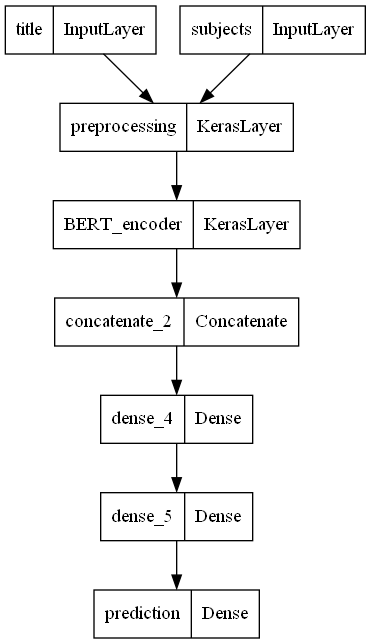

In [18]:
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3"
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4"
hidden_layer_sizes = [300, 100]
alpha_leaky_relu = 0.01
dropout = 0
number_of_output_classes = 3

def build_classifier_model():
    # Handle categorical labels
    # encoded_stance = get_category_encoding_layer(name='categorical', dataset=data_train, dtype='string')

    # BERT embeddings
    preprocessor = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')

    title = tf.keras.layers.Input(shape=(), dtype=tf.string, name='title')
    titles_preprocessed = preprocessor(title)

    subjects = tf.keras.layers.Input(shape=(), dtype=tf.string, name='subjects')
    subjects_preprocessed = preprocessor(subjects)

    # pooled_output gives the embedding per input sequence, alternatively sequence_output would give it per input token
    titles_embedded = encoder(titles_preprocessed)["pooled_output"]
    subjects_embedded = encoder(subjects_preprocessed)["pooled_output"]

    # Concat features
    # titles_embedded = tf.keras.layers.Flatten()(titles_embedded)
    # subjects_embedded = tf.keras.layers.Flatten()(subjects_embedded)
    concatenated_features = tf.keras.layers.Concatenate()([titles_embedded, subjects_embedded])
    out = concatenated_features

    # Neural network hidden layers
    for number_of_hidden_units in hidden_layer_sizes:
        out = tf.keras.layers.Dense(number_of_hidden_units, activation=tf.keras.layers.LeakyReLU(alpha=alpha_leaky_relu))(out)
        if dropout > 0:
            out = tf.keras.layers.Dropout(dropout)(out)

    # Output
    out = tf.keras.layers.Dense(number_of_output_classes, activation=tf.nn.softmax, name='prediction')(out)

    return tf.keras.Model(
        inputs = [title, subjects],
        outputs = out
    )

# In case of "SavedModel file does not exist at:" error, go the Temp\tfhub_modules folder it references and delete it
model = build_classifier_model()
model.summary()
tf.keras.utils.plot_model(model)

In [19]:
# steps_per_epoch = tf.data.experimental.cardinality(data_train).numpy()
# num_train_steps = steps_per_epoch * epochs
# num_warmup_steps = int(0.1*num_train_steps)
#
# init_lr = 3e-5
# optimizer = tf.keras.optimizers.create_optimizer( init_lr=init_lr,
#                                                   num_train_steps=num_train_steps,
#                                                   num_warmup_steps=num_warmup_steps,
#                                                   optimizer_type='adamw')

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

epochs=15
history = model.fit(
    x=[
        X_train['title'],
        X_train['subjects']
    ],
    y=y_train,
    epochs=epochs,
    validation_data=([X_test['title'], X_test['subjects']], y_test)
)


Epoch 1/15
12/12 [==============================] - 312s 26s/step - loss: 1.1289 - accuracy: 0.4151 - val_loss: 1.1088 - val_accuracy: 0.4127
Epoch 2/15
12/12 [==============================] - 300s 26s/step - loss: 1.0723 - accuracy: 0.4621 - val_loss: 1.0504 - val_accuracy: 0.4074
Epoch 3/15
12/12 [==============================] - 300s 26s/step - loss: 1.0228 - accuracy: 0.4883 - val_loss: 1.0575 - val_accuracy: 0.4656
Epoch 4/15
12/12 [==============================] - 303s 26s/step - loss: 1.0000 - accuracy: 0.5013 - val_loss: 1.0054 - val_accuracy: 0.4444
Epoch 5/15
12/12 [==============================] - 300s 26s/step - loss: 0.9584 - accuracy: 0.5300 - val_loss: 1.0019 - val_accuracy: 0.4550
Epoch 6/15
12/12 [==============================] - 290s 25s/step - loss: 0.9330 - accuracy: 0.5561 - val_loss: 1.0004 - val_accuracy: 0.4550
Epoch 7/15
12/12 [==============================] - 278s 25s/step - loss: 0.9135 - accuracy: 0.5509 - val_loss: 0.9859 - val_accuracy: 0.5132
Epoch 

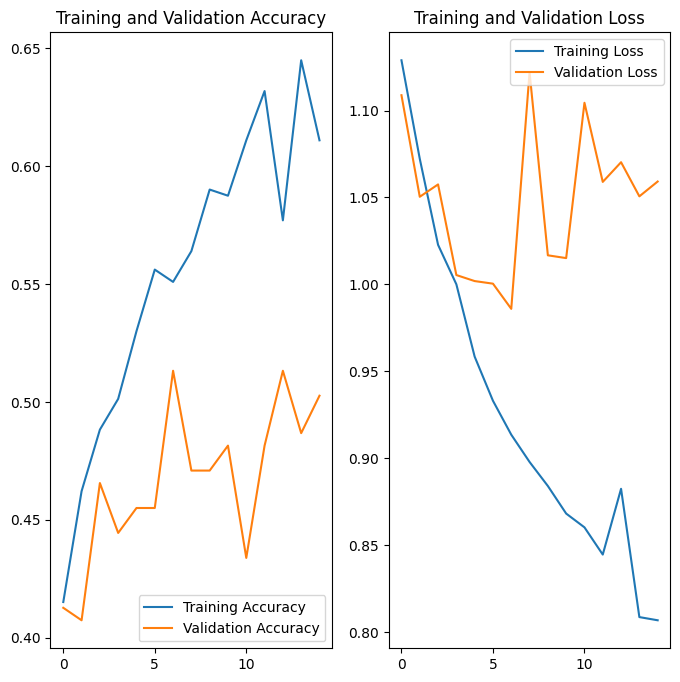

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
data_path = ( Path.cwd() / "models/stance_model_v4").resolve()
model.save(data_path)

2023-01-01 15:14:44,124 WARNING: Found untraced functions such as leaky_re_lu_4_layer_call_fn, leaky_re_lu_4_layer_call_and_return_conditional_losses, leaky_re_lu_5_layer_call_fn, leaky_re_lu_5_layer_call_and_return_conditional_losses, restored_function_body while saving (showing 5 of 370). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: C:\Users\steem\Desktop\ScalableStance\Pipeline\models\stance_model_v4\assets
2023-01-01 15:14:48,159 INFO: Assets written to: C:\Users\steem\Desktop\ScalableStance\Pipeline\models\stance_model_v4\assets
